### Cointegrated Augmented Dickey-Fuller Test

An inquisitive reader may ask: Why do we need any new tests for the stationarity of the portfolio price series, when we already have the trusty ADF and Variance Ratio tests for stationarity? The answer is that given a number of price series, we do not know a priori what hedge ratios we should use to combine them to form a stationary portfolio. (The hedge ratio of a particular asset is the number of units of that asset we should be long or short in a portfolio. If the asset is a stock, then the number of units corresponds to the number of shares. A negative hedge ratio indicates we should be short that asset.) Just because a set of price series is cointegrating does not mean that any random linear combination of them will form a stationary portfolio. But pursuing this line of thought further, what if we first determine the optimal hedge ratio by running a linear regression fit between two price series, use this hedge ratio to form a portfolio, and then finally run a stationarity test on this portfolio price series? This is essentially what [Engle and Granger (1987)](https://www.ntuzov.com/Nik_Site/Niks_files/Research/papers/stat_arb/EG_1987.pdf) did. For our convenience, the statsmodels package has provided a [cadf](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html) function that performs all these steps. Example 2.6 demonstrates how to use this function by applying it to the two exchange-traded funds (ETFs) EWA and EWC.

### Example 2.6: Using the CADF Test for Cointegration

ETFs provide a fertile ground for finding cointegrating price series—and thus good candidates for pair trading. For example, both Canadian and Australian economies are commodity based, so they seem likely to cointegrate. We assume the price series of EWA is contained in the array x, and that of EWC is contained in the array y.

<Axes: xlabel='April 4, 2006, to April 9, 2012', ylabel='Share price $'>

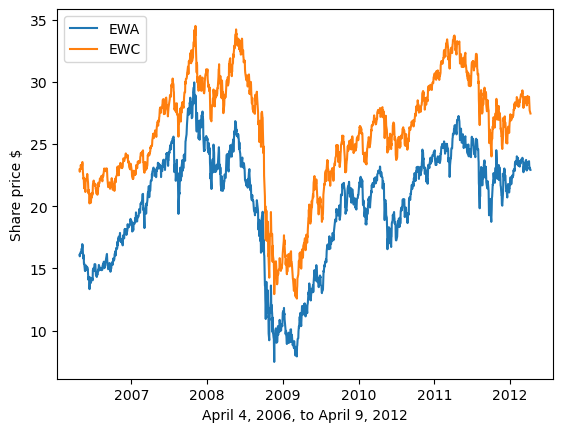

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts

df=pd.read_csv('inputData_EWA_EWC_IGE.csv')
df['Date']=pd.to_datetime(df['Date'], format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

df[['EWA', 'EWC']].plot(
    xlabel='April 4, 2006, to April 9, 2012', ylabel='Share price $')

**FIGURE 2.4** Share Prices of EWA versus EWC

From Figure 2.4, we can see that they do look quite cointegrating.

A scatter plot of EWA versus EWC in Figure 2.5 is even more convincing, as the price pairs fall on a straight line.

<Axes: xlabel='EWA share price', ylabel='EWC share price'>

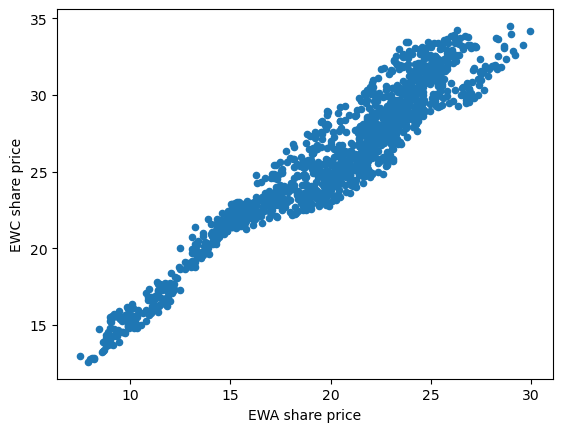

In [2]:
df.plot.scatter(x='EWA', y='EWC',
                xlabel='EWA share price', ylabel='EWC share price')

**FIGURE 2.5** Scatter Plot of EWA versus EWC

We can use the [ols](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) function found in the statsmodels package to find the optimal hedge ratio.

Intercept    6.411331
EWA          0.962429
dtype: float64
hedgeRatio=0.962429


<Axes: xlabel='April 4, 2006, to April 9, 2012', ylabel='EWC-hedgeRatio*EWA'>

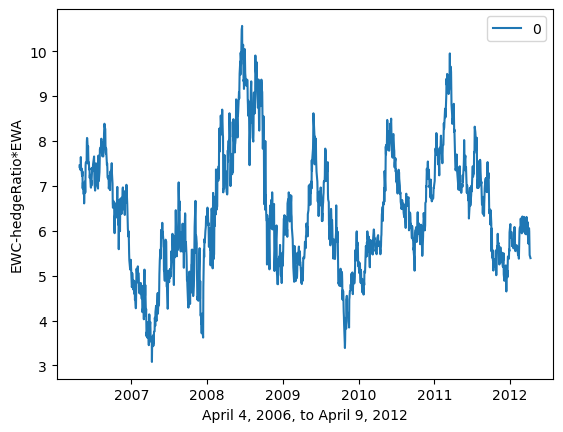

In [3]:
results=sm.ols(formula="EWC ~ EWA", data=df[['EWA', 'EWC']]).fit()
print(results.params)
hedgeRatio=results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

pd.DataFrame((df['EWC']-hedgeRatio*df['EWA'])).plot(
    xlabel='April 4, 2006, to April 9, 2012', ylabel='EWC-hedgeRatio*EWA')

**FIGURE 2.6** Stationarity of Residuals of Linear Regression between EWA versus EWC

As expected, the plot of the residual EWC-hedgeRatio*EWA in Figure 2.6 does look very stationary.

We use the [cadf](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html) function of the statsmodels package for our test. Other than an extra input for the second price series, the inputs are the same as the adf function. We again assume that there can be a nonzero offset of the pair portfolio’s price series, but the drift is zero. Note that in both the regression and the CADF test we have chosen EWA to be the independent variable x, and EWC to be the dependent variable y. If we switch the roles of EWA and EWC, will the result for the CADF test differ? Unfortunately, the answer is “yes.” The hedge ratio derived from picking EWC as the independent variable will not be the exact reciprocal of the one derived from picking EWA as the independent variable. In many cases (though not for EWA-EWC, as we shall confirm later with Johansen test), only one of those hedge ratios is “correct,” in the sense that only one hedge ratio will lead to a stationary portfolio. If you use the CADF test, you would have to try each variable as independent and see which order gives the best (most negative) t-statistic, and use that order to obtain the hedge ratio. For brevity, we will just assume EWA to be independent, and run the CADF test.

In [4]:
# cadf test
coint_t, pvalue, crit_value=ts.coint(df['EWA'], df['EWC'])
print('t-statistic=%f' % coint_t)
print('pvalue=%f' % pvalue)
print(crit_value)

t-statistic=-3.063528
pvalue=0.095866
[-3.90376106 -3.34020915 -3.04728056]


We find that the ADF test statistic is about -3.06, certainly more negative than the critical value at the 90 percent level of -3.047. So we can reject the null hypothesis that λ is zero. In other words, EWA and EWC are cointegrating with 90 percent certainty.